In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf

import keras
import keras.backend as K

from tqdm import tqdm

from concurrent.futures import ThreadPoolExecutor

%matplotlib inline

In [2]:
IMAGES_DIRECTORY = os.path.join("/kaggle/input/marketplace-navigation-dataset/dataset/images")
LABELS_PATH = os.path.join("/kaggle/input/marketplace-navigation-dataset/dataset/market_dataset_xy.txt")
DRONET_PATH = os.path.join("/kaggle/input/marketplace-navigation-dataset/model.keras")

#     x = keras.layers.GlobalAveragePooling2D(name="global_pool")(base.output)
    x = keras.layers.Dropout(dropout_rate, name="dropout")(x)Loading Dataset

In [3]:
def create_dataset(file_paths, labels, batch_size=32, shuffle=True, augment=False):
    def augment_fn(image, label):
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
        do_flip = tf.random.uniform([]) > 0.5
        image = tf.cond(do_flip, lambda: tf.image.flip_left_right(image), lambda: image)
        label = tf.cond(do_flip, lambda: tf.stack([-label[0], label[1]]), lambda: label)
    
        return image, label

    def load_image_fn(image_path: str):
        image = keras.utils.load_img(
            image_path,
            color_mode="rgb",
            target_size=(200, 200),
            interpolation="bilinear"
        )
        
        image = np.asarray(image, dtype=np.float32) / 255.0
        image = image[..., np.newaxis]

        return image
    
    with ThreadPoolExecutor(max_workers=4) as executor:
        images = list(tqdm(
            executor.map(
                load_image_fn,
                file_paths
            ),
            total=len(file_paths)
        ))
    
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images), reshuffle_each_iteration=True)

    if augment:
        dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.map(lambda x, y: (x, {"vel_x": y[0], "vel_y": y[1]}))
    dataset = dataset.batch(batch_size)

    return dataset

In [4]:
@tf.function
def mae(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])
    
    return tf.reduce_sum(tf.abs(y_true - y_pred))

@tf.function
def r2_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])
    
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    
    return 1 - (ss_res / (ss_tot + K.epsilon()))
    
@tf.function
def rmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])
    
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

@tf.function
def eva(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])

    numerator = tf.math.reduce_variance(y_true - y_pred)
    denominator = tf.math.reduce_variance(y_true) + tf.keras.backend.epsilon()
    
    return 1.0 - numerator / denominator

In [5]:
df = pd.read_csv(LABELS_PATH, sep=" ", header=None, names=["file name", "_", "datetime", "y_vel", "x_vel"])
df = df[["file name", "x_vel", "y_vel"]]
df["file name"] = df["file name"].apply(lambda name: os.path.join(IMAGES_DIRECTORY, name))

train_df, temp_df = train_test_split(df, test_size=0.4, random_state=0)
val_df, test_df   = train_test_split(temp_df, test_size=0.5, random_state=0)

def extract_data(df):
    return df["file name"].to_numpy(), df[["x_vel", "y_vel"]].to_numpy()

X_train, y_train = extract_data(train_df)
X_val,   y_val   = extract_data(val_df)
X_test,  y_test  = extract_data(test_df)

train_dataset      = create_dataset(X_train, y_train, batch_size=32, augment=True,  shuffle=True)
validation_dataset = create_dataset(X_val,   y_val,   batch_size=32, augment=False, shuffle=False)
test_dataset       = create_dataset(X_test,  y_test,  batch_size=32, augment=False, shuffle=False)

100%|██████████| 454/454 [00:25<00:00, 17.87it/s]


In [6]:
def create_mobile_net_v1(learning_rate, name="MobileNetV1", input_shape=(200, 200, 3)):
    # 1) Instantiate MobileNet with its own Input layer
    base = keras.applications.MobileNet(
        input_shape=input_shape,
        include_top=False,
        weights=None,
        pooling=None,    # we’ll apply pooling ourselves
        alpha=1.0,
    )

    # 2) Build on top of base.output
    x = keras.layers.GlobalAveragePooling2D(name="global_pool")(base.output)
    x = keras.layers.Dropout(0.3, name="dropout")(x)
    x = keras.layers.BatchNormalization(name="bn")(x)

    vel_x = keras.layers.Dense(1, activation="linear", name="vel_x")(x)
    vel_y = keras.layers.Dense(1, activation="linear", name="vel_y")(x)

    # 4) Tie it all together
    model = keras.Model(
        inputs=base.input,
        outputs=[vel_x, vel_y],
        name=name
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss={"vel_x": "mse", "vel_y": "mse"},
        loss_weights={"vel_x": 1.0, "vel_y": 1.0},
        metrics={
            "vel_x": [eva, rmse, r2_score],
            "vel_y": [eva, rmse, r2_score],
        },
    )
    return model


In [7]:
def create_mobile_net_v2(learning_rate, name="MobileNetV2", input_shape=(200, 200, 3)):
    base = keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights=None,
        pooling=None,
        alpha=1.0,
    )

    x = keras.layers.GlobalAveragePooling2D(name="global_pool")(base.output)
    x = keras.layers.Dropout(0.3, name="dropout")(x)
    x = keras.layers.BatchNormalization(name="bn")(x)

    vel_x = keras.layers.Dense(1, activation='linear', name='vel_x')(x)
    vel_y = keras.layers.Dense(1, activation='linear', name='vel_y')(x)

    model = keras.models.Model(inputs=base.input, outputs=[vel_x, vel_y], name="MobileNetV2_Scratch")

    model.compile(
        loss={
            "vel_x": "mean_squared_error",
            "vel_y": "mean_squared_error",
        },
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics={
            "vel_x": [eva, rmse, r2_score],
            "vel_y": [eva, rmse, r2_score],
        },
    )
    
    return model

In [8]:
def create_efficient_net(learning_rate, name="EfficientNet", input_shape=(200, 200, 3)):
    base = keras.applications.EfficientNetB0(
        input_shape=input_shape,
        include_top=False,
        weights=None,
        pooling=None,
    )

    x = keras.layers.GlobalAveragePooling2D(name="global_pool")(base.output)
    x = keras.layers.Dropout(0.3, name="dropout")(x)
    x = keras.layers.BatchNormalization(name="bn")(x)

    vel_x = keras.layers.Dense(1, activation='linear', name='vel_x')(x)
    vel_y = keras.layers.Dense(1, activation='linear', name='vel_y')(x)

    model = keras.models.Model(inputs=base.inputs, outputs=[vel_x, vel_y], name="EfficientNetB0_Scratch")

    model.compile(
        loss={
            "vel_x": "mean_squared_error",
            "vel_y": "mean_squared_error",
        },
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics={
            "vel_x": [eva, rmse, r2_score],
            "vel_y": [eva, rmse, r2_score],
        },
    )
    
    return model

In [9]:
def create_dronet(learning_rate, name="Dronet", top_layers=(), batch_norm_layers=()):
    def residual_block(x, filters, kernel_size=3, stride=1):
        shortcut = x
        x = keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)
    
        x = keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
        x = keras.layers.BatchNormalization()(x)
    
        if stride != 1 or shortcut.shape[-1] != filters:
            shortcut = keras.layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
            shortcut = keras.layers.BatchNormalization()(shortcut)
    
        x = keras.layers.Add()([x, shortcut])
        x = keras.layers.ReLU()(x)
    
        return x
    
    inputs = keras.Input(shape=(200, 200, 3))

    # Initial convolution (not in the paper explicitly, but assumed before residual blocks)
    x = keras.layers.Conv2D(32, kernel_size=5, strides=2, padding='same', use_bias=False)(inputs)  # (100, 100, 32)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D(pool_size=2)(x)

    # 3 residual blocks as per ResNet-8 (simplified)
    x = residual_block(x, 32)
    x = residual_block(x, 64, stride=2)
    x = residual_block(x, 128, stride=2)

    # Global Average Pooling and shared dropout + ReLU
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.3)(x)

    for i, units in enumerate(top_layers):
        use_batch_norm = i in batch_norm_layers
        use_bias = not use_batch_norm
        
        x = keras.layers.Dense(units, name=f"{name}_dense_{i}", use_bias=use_bias)(x)

        if use_batch_norm:
            x = keras.layers.BatchNormalization(name=f"{name}_batch_norm_{i}")(x)

        x = keras.layers.ReLU(name=f"{name}_relu_{i}")(x)
            
    vel_x = keras.layers.Dense(1, activation='linear', name='vel_x')(x)
    vel_y = keras.layers.Dense(1, activation='linear', name='vel_y')(x)

    model = keras.models.Model(inputs=inputs, outputs=[vel_x, vel_y], name=name)

    model.compile(
        loss={
            "vel_x": "mean_squared_error",
            "vel_y": "mean_squared_error",
        },
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics={
            "vel_x": [eva, rmse, r2_score],
            "vel_y": [eva, rmse, r2_score],
        },
    )

    return model

In [10]:
def train_model(model, train_dataset, validation_dataset):    
    return model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=200,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=45,
                min_delta=1e-4,
                mode="min",
                restore_best_weights=True,
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss",
                patience=15,
                factor=0.5,
                min_lr=1e-7,
                mode="min"
            ),
        ],
    )

In [11]:
def plot_training(histories):
    rows = len(histories)
    columns = 2
    figsize = (columns * 4, rows * 4)

    fig, ax = plt.subplots(rows, columns, figsize=figsize, layout="tight")

    for index, history in enumerate(histories):
        ax[index, 0].plot(np.gradient(history.history["vel_x_rmse"]), label="Training RMSE")
        ax[index, 0].plot(np.gradient(history.history["val_vel_x_rmse"]), label="Validation RMSE")
        ax[index, 0].legend()
        ax[index, 0].set_title(f"{history.model.name} Horizontal speed gradient")
        
        ax[index, 1].plot(np.gradient(history.history["vel_y_rmse"]), label="Training RMSE")
        ax[index, 1].plot(np.gradient(history.history["val_vel_y_rmse"]), label="Validation RMSE")
        ax[index, 1].legend()
        ax[index, 1].set_title(f"{history.model.name} Vertical speed gradient")

    return fig

In [12]:
def compare_models_performances(models, test_dataset):
    metrics = {}
    
    for model in models:
        metrics_names = [
            "MSE", "Horizontal EVA", "Horizontal R²", "Horizontal RMSE",
            "Vertical EVA", "Vertical R²", "Vertical RMSE"
        ]
        model_metrics = model.evaluate(test_dataset, verbose=0)
        model_metrics = dict(zip(metrics_names, model_metrics))
        metrics[model.name] = model_metrics

    return pd.DataFrame(metrics).T

In [13]:
def plot_models_comparisons(models, test_dataset):
    rows = len(models)
    columns = 4
    figsize = (columns * 4, rows * 4)
    
    fig, ax = plt.subplots(rows, columns, figsize=figsize, layout="compressed")
    
    for i, model in enumerate(models):
        y_true, y_pred = [], []
        
        for sample_batch, y_true_batch in test_dataset:
            y_pred_batch = model.predict(sample_batch, verbose=0)
            y_pred_batch = np.hstack(y_pred_batch)

            y_true_batch = np.array([
                y_true_batch["vel_x"],
                y_true_batch["vel_y"],
            ])
            y_true_batch= y_true_batch.T

            y_true.append(y_true_batch)
            y_pred.append(y_pred_batch)

        y_true = np.vstack(y_true)
        y_pred = np.vstack(y_pred)
        
        x_residuals = y_true[:, 0] - y_pred[:, 0]
        x_limits = np.max(np.fabs(x_residuals))
        x_limits = (-x_limits, +x_limits)
    
        y_residuals = y_true[:, 1] - y_pred[:, 1]
        y_limits = np.max(np.fabs(y_residuals))
        y_limits = (-y_limits, +y_limits)
    
        ax[i, 0].scatter(y_true[:, 0], y_pred[:, 0])
        ax[i, 0].set_title(f"{model.name}\nHorizintal speed scatter")
        ax[i, 0].set_xlabel("Actual values")
        ax[i, 0].set_ylabel("Predicted values")
        
        ax[i, 1].hist(x_residuals)
        ax[i, 1].set_title(f"{model.name}\nHorizontal prediction errors distribution")
        ax[i, 1].set_ylabel("Error")
        ax[i, 1].set_xlim(x_limits)
    
        ax[i, 2].scatter(y_true[:, 1], y_pred[:, 1])
        ax[i, 2].set_title(f"{model.name}\nVertical speed scatter")
        ax[i, 2].set_xlabel("Actual values")
        ax[i, 2].set_ylabel("Predicted values")

        ax[i, 3].hist(y_residuals)
        ax[i, 3].set_title(f"{model.name}\nVertical prediction errors distribution")
        ax[i, 3].set_ylabel("Error")
        ax[i, 3].set_xlim(y_limits)

    return fig

  0%|          | 0/3 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1746539686.325553      70 service.cc:145] XLA service 0x7c2a8c0026f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746539686.325639      70 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746539699.405987      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 3/3 [30:03<00:00, 601.05s/it]


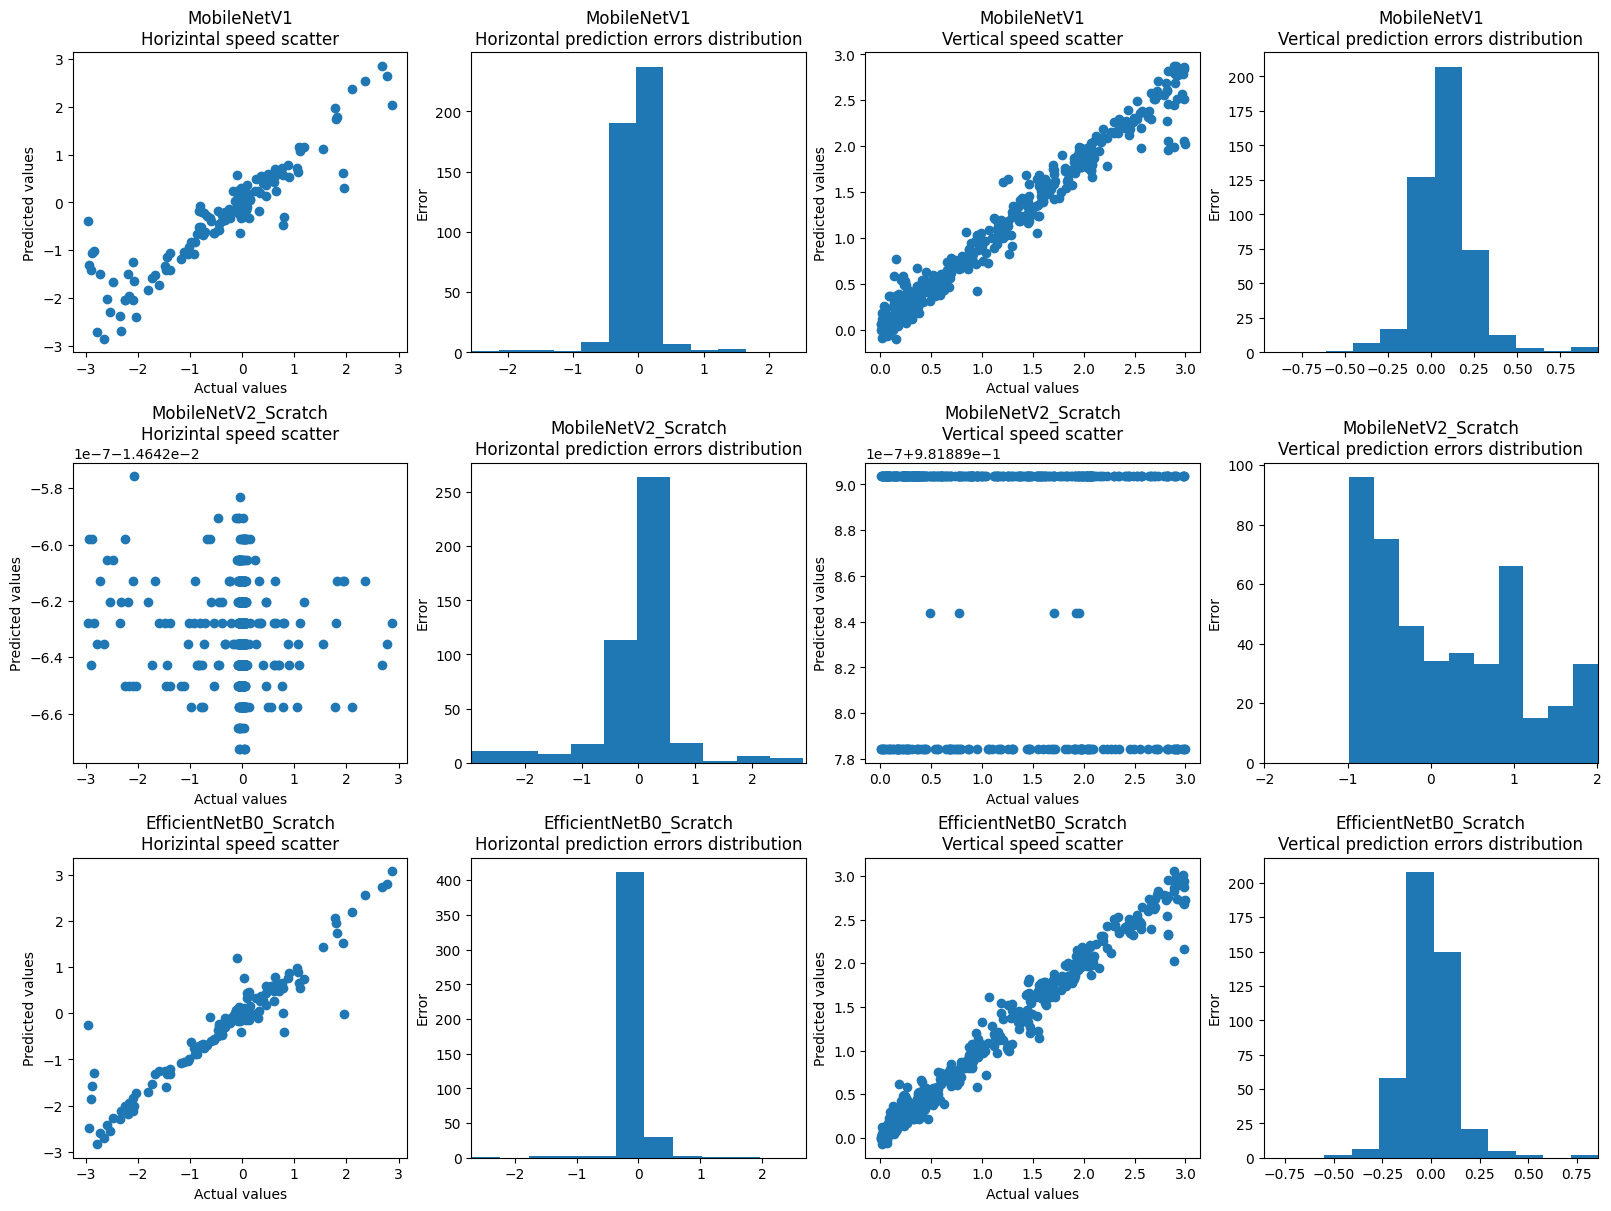

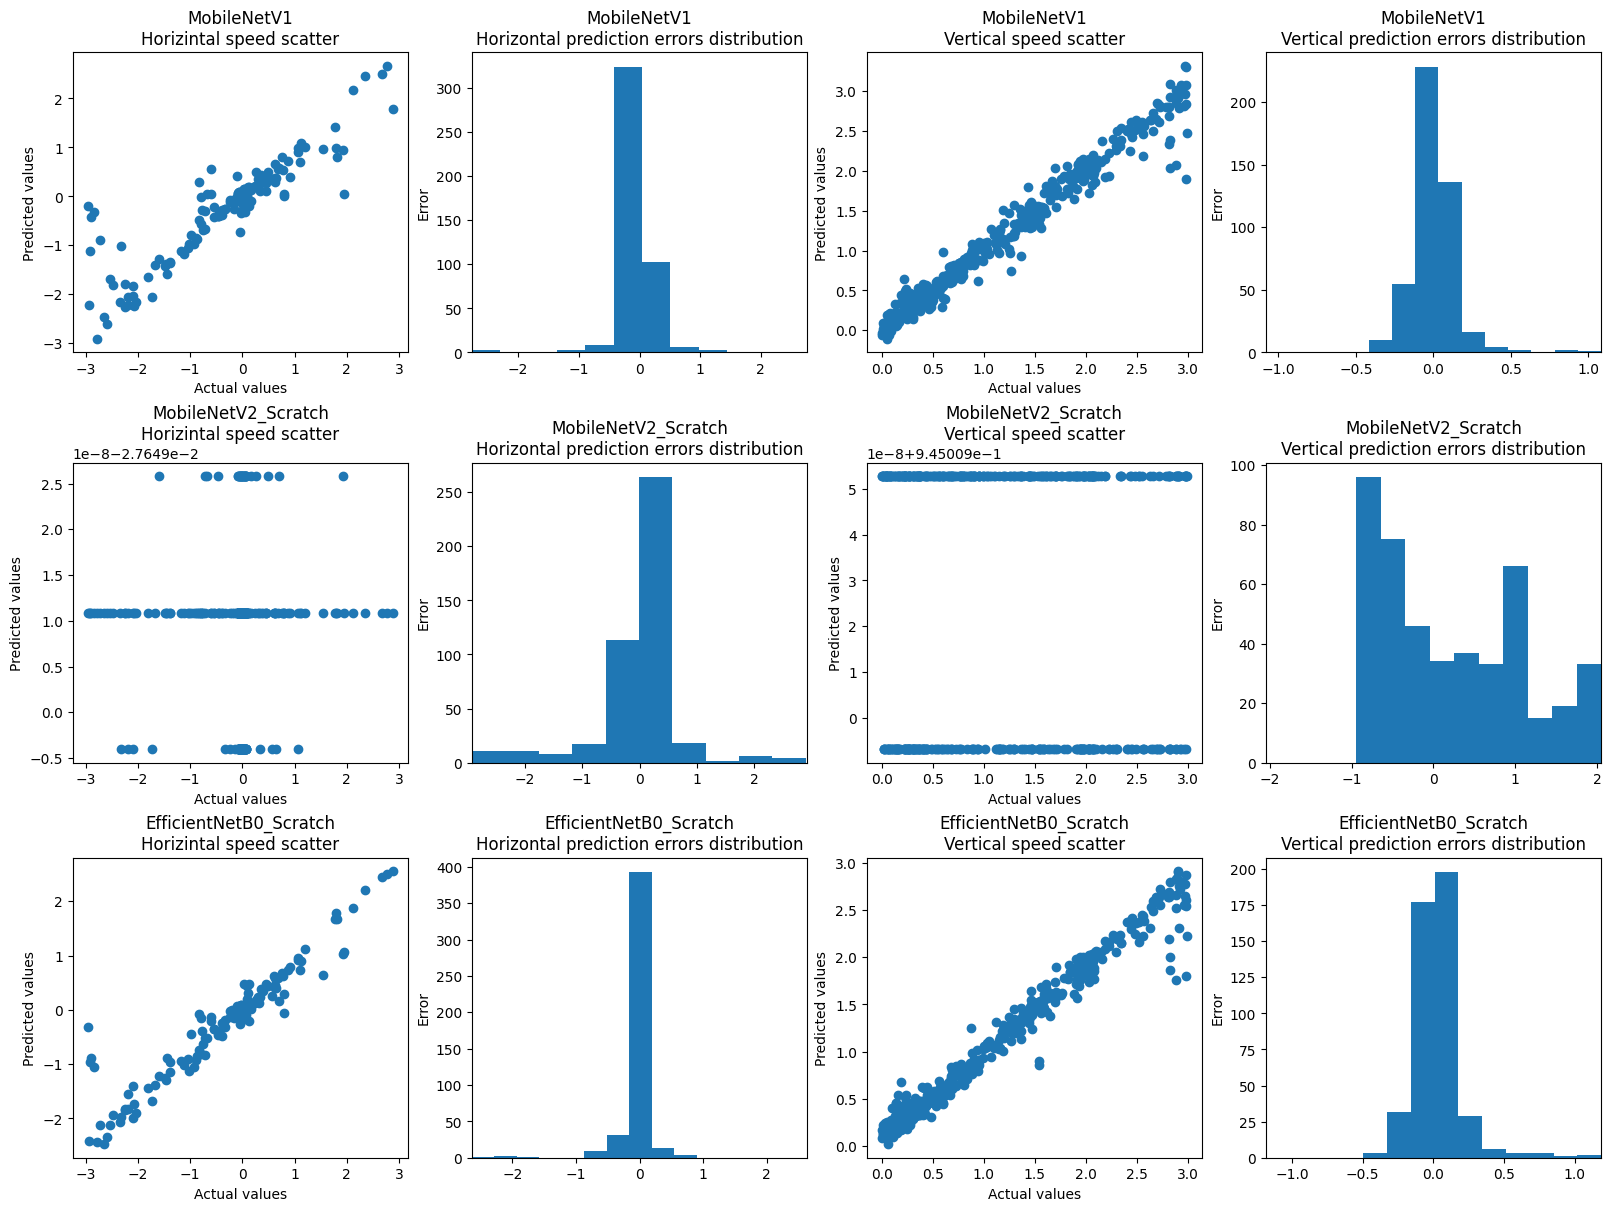

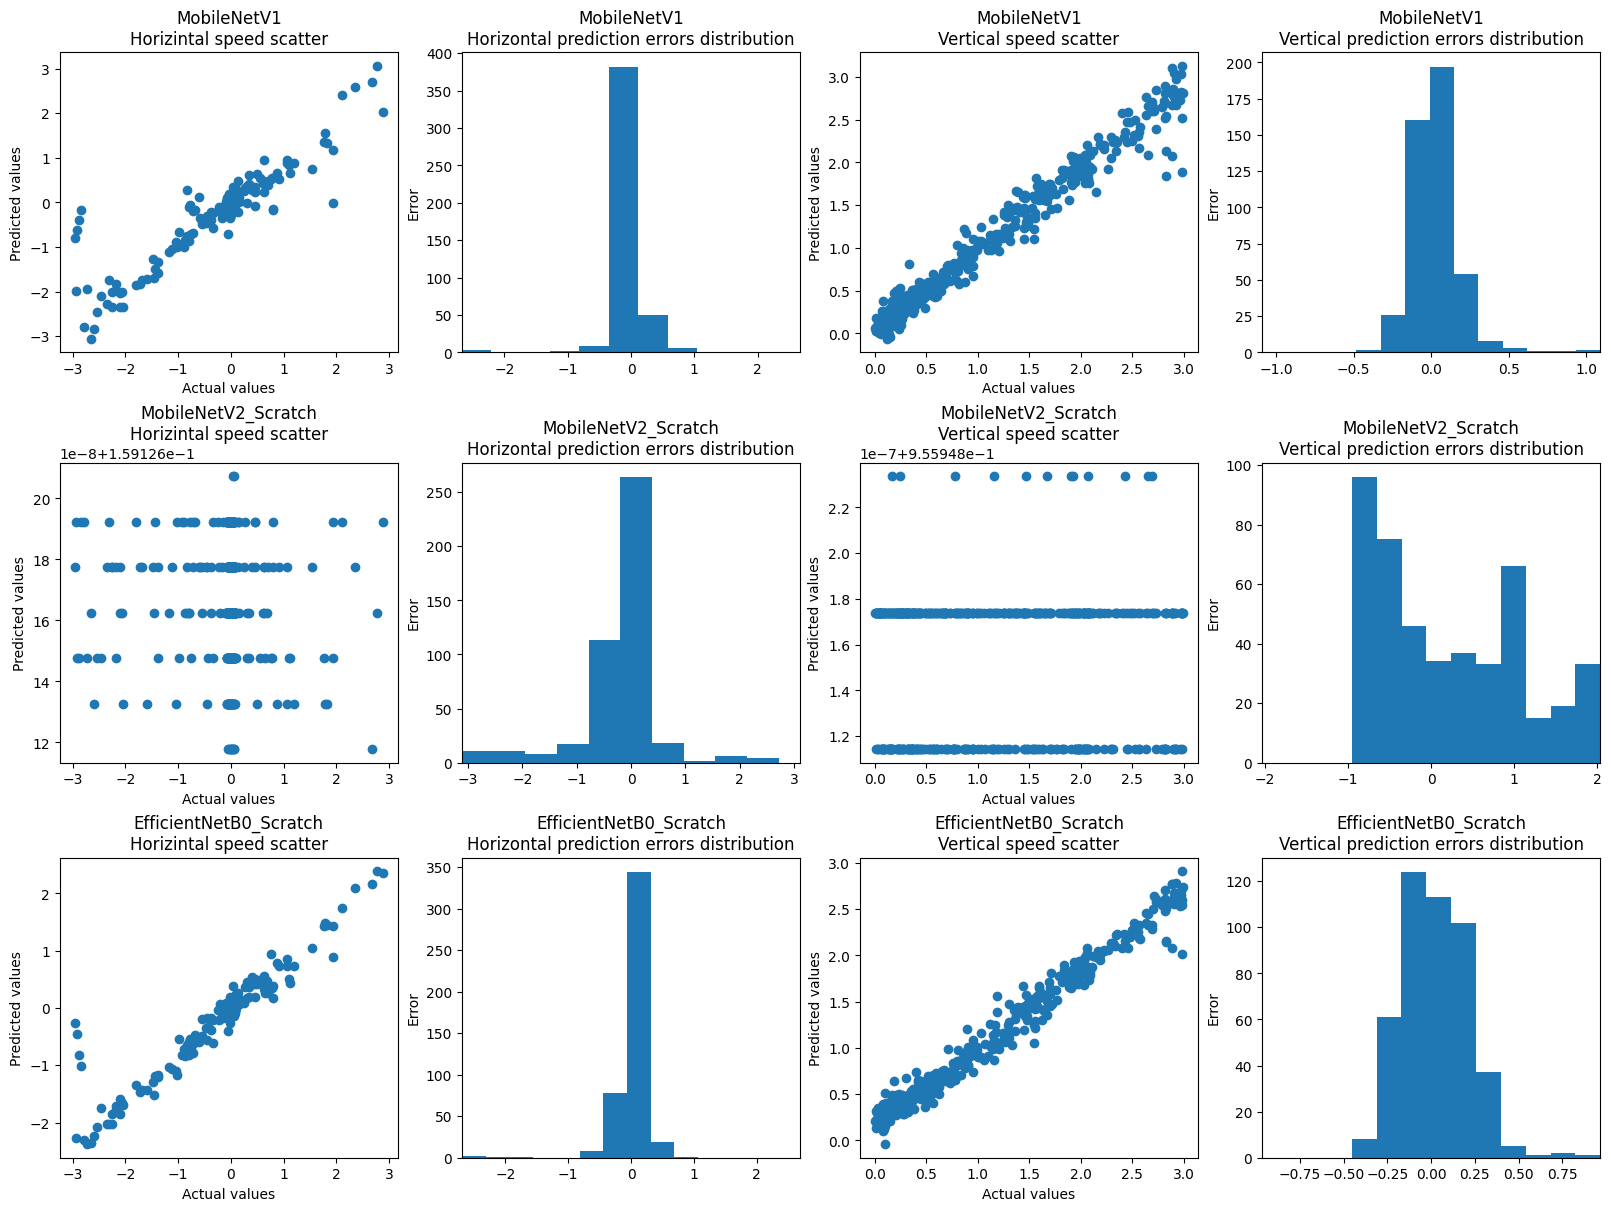

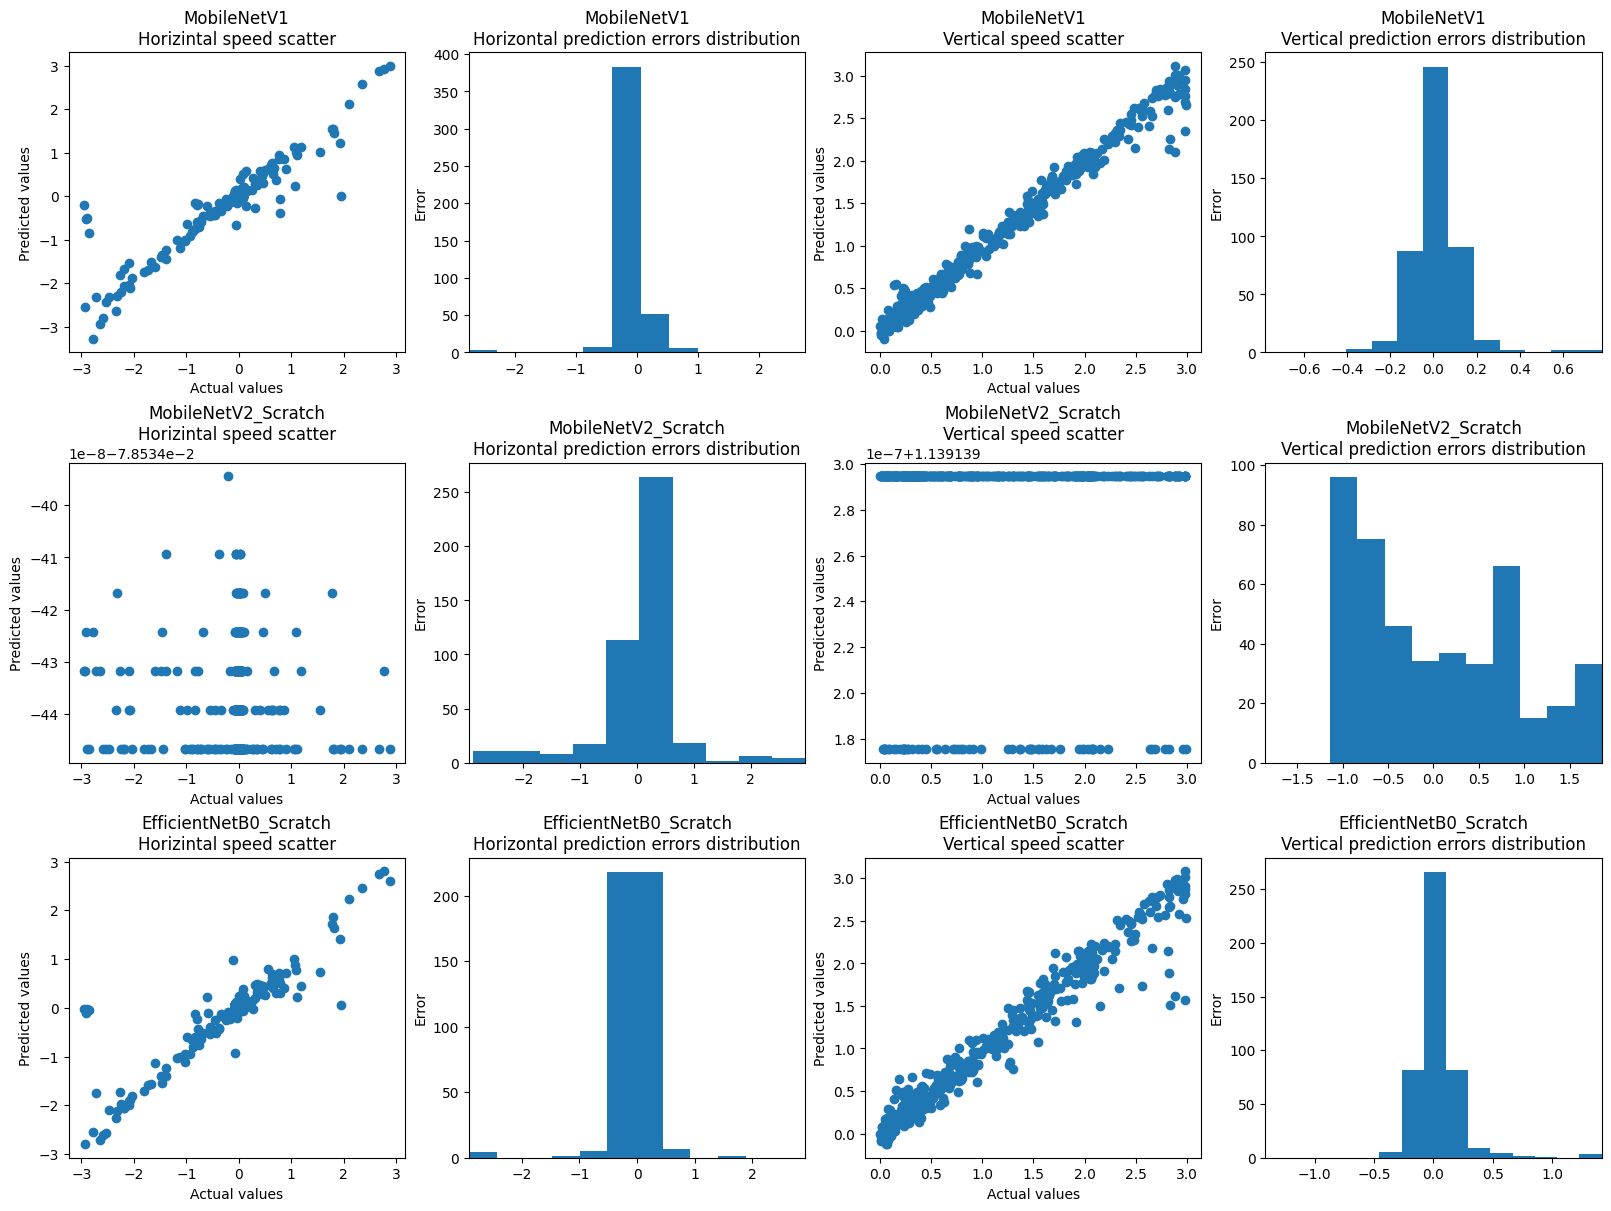

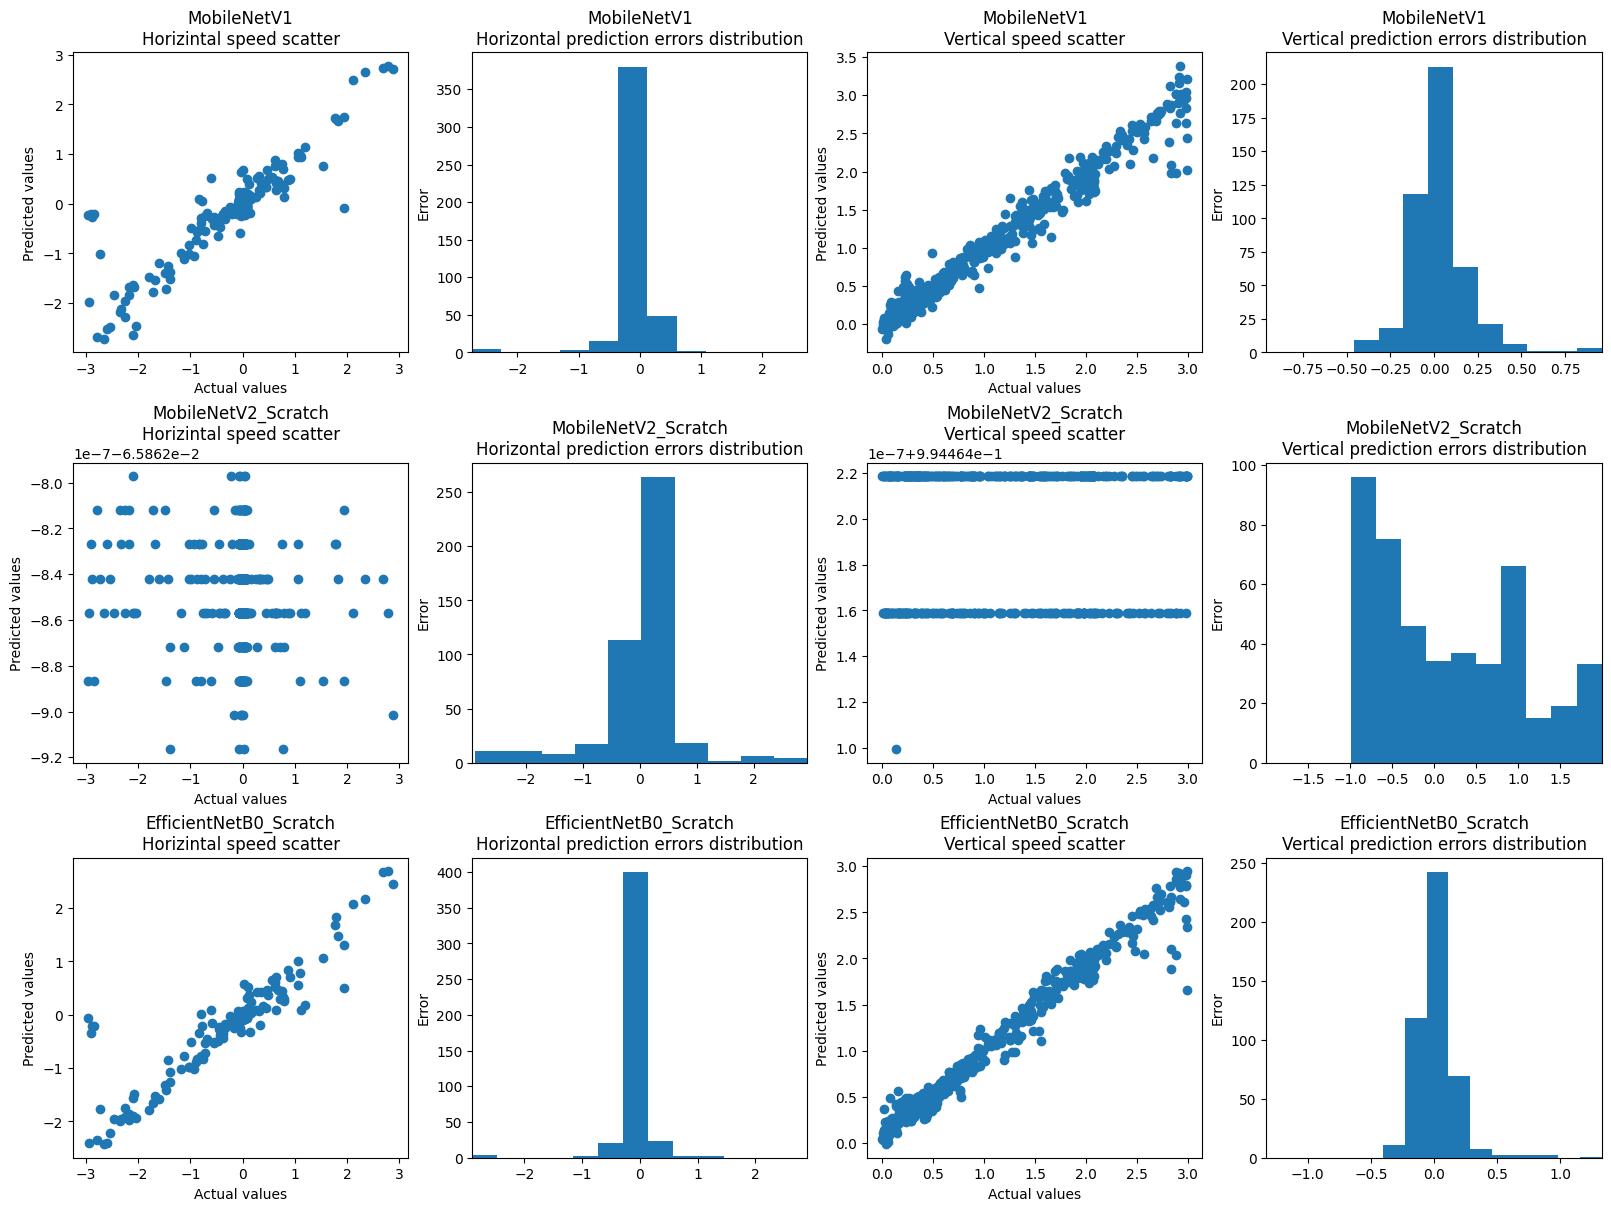

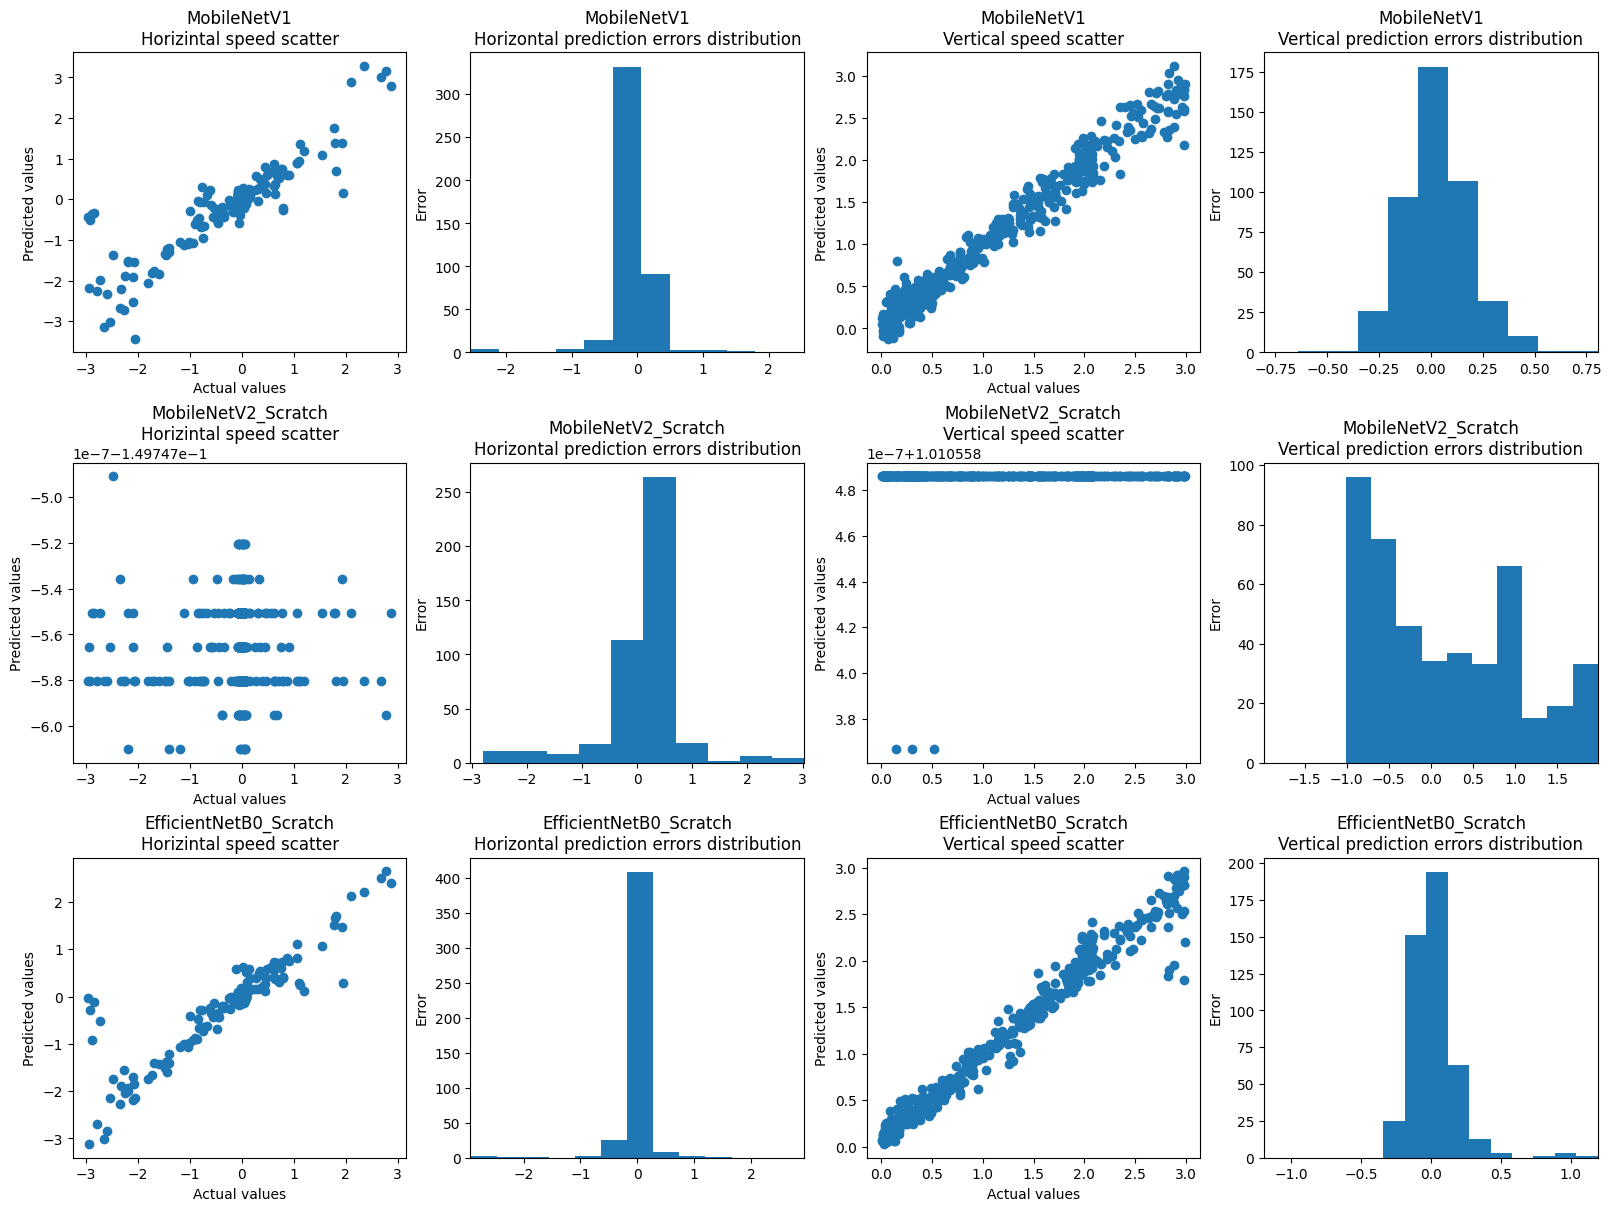

In [14]:
rounds = 6

if os.path.exists("results"):
    shutil.rmtree("results")

os.mkdir("results")
for i in range(1, rounds + 1):
    os.mkdir(f"results/round_{i}")
    os.mkdir(f"results/round_{i}/histories")

for i in range(1, rounds + 1):
    models = [
        create_mobile_net_v1(0.001, name="MobileNetV1"),
        create_mobile_net_v2(0.001, name="MobileNetV2"),
        create_efficient_net(0.001, name="EfficientNet"),
        # create_dronet(0.001, name="DR-000A", top_layers=(), batch_norm_layers=()),
        # create_dronet(0.001, name="DR-540A", top_layers=(32, 16), batch_norm_layers=()),
        # create_dronet(0.001, name="DR-540B", top_layers=(32, 16), batch_norm_layers=(1, 2)),
        # create_dronet(0.001, name="DR-650A", top_layers=(64, 32), batch_norm_layers=()),
        # create_dronet(0.001, name="DR-650B", top_layers=(64, 32), batch_norm_layers=(1, 2)),
    ]
        
    histories = [train_model(model, train_dataset, validation_dataset) for model in tqdm(models)]

    metrics = compare_models_performances(models, test_dataset)
    model_comparison_fig = plot_models_comparisons(models, test_dataset)
    
    metrics.to_csv(f"results/round_{i}/metrics.csv")
    for history in histories:
        pd.DataFrame(history.history).to_csv(f"results/round_{i}/histories/{history.model.name}.csv")